In [12]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure
from skimage.morphology import skeletonize
from sklearn.preprocessing import MinMaxScaler
from skimage.morphology import skeletonize
from skimage import img_as_ubyte


In [13]:
# Paths to the FVC dataset folders
np_data_path = './dataset/np_data'
train_data_path = './dataset/train_data'
real_data_path = './dataset/real_data'

In [14]:
# Function to load images from a folder (supports different file extensions)
def load_images_from_folder(folder, extension='.bmp'):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(extension):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
    return images


In [15]:
# Function to load .npy files from np_data folder
def load_npy_files_from_folder(folder):
    npy_files = []
    for filename in os.listdir(folder):
        if filename.endswith('.npy'):
            file_path = os.path.join(folder, filename)
            data = np.load(file_path)
            npy_files.append(data)
    return npy_files

In [16]:
# Load .bmp images from train_data and real_data folders
train_images = load_images_from_folder(train_data_path, extension='.bmp')
real_images = load_images_from_folder(real_data_path, extension='.bmp')

# Load .npy files from np_data folder (if needed for further use)
np_data = load_npy_files_from_folder(np_data_path)

# Check number of images loaded
print("Number of images in train_data:", len(train_images))
print("Number of images in real_data:", len(real_images))
print("Number of .npy files in np_data:", len(np_data))

Number of images in train_data: 800
Number of images in real_data: 10
Number of .npy files in np_data: 4


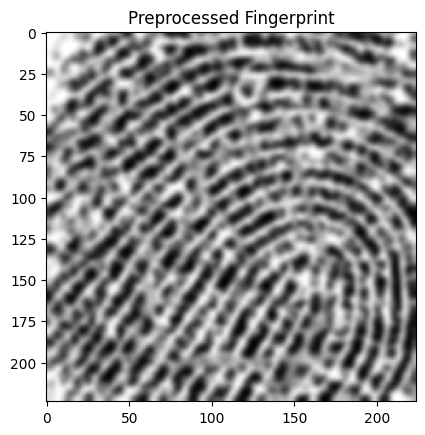

In [17]:
# Function for preprocessing: Enhance contrast, reduce noise, and resize images
def preprocess_image(img, target_size=(224, 224)):
    # Enhance contrast using Histogram Equalization
    img_eq = cv2.equalizeHist(img)

    # Apply Gaussian blur to reduce noise
    img_blurred = cv2.GaussianBlur(img_eq, (5, 5), 0)

    # Resize image to target size
    img_resized = cv2.resize(img_blurred, target_size)

    return img_resized

# Preprocess the .bmp images
train_images_preprocessed = [preprocess_image(img) for img in train_images]
real_images_preprocessed = [preprocess_image(img) for img in real_images]

# Display a sample image after preprocessing
plt.imshow(train_images_preprocessed[0], cmap='gray')
plt.title("Preprocessed Fingerprint")
plt.show()

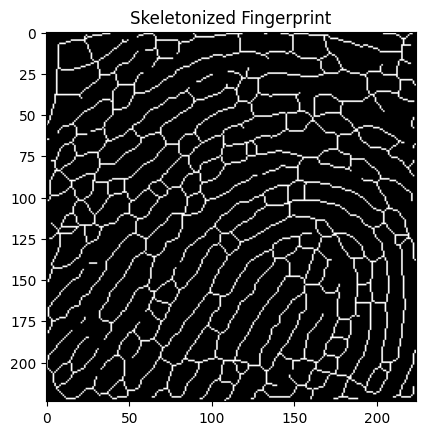

In [18]:
# Function to convert image to skeletonized form for Crossing Number
def skeletonize_image(img):
    # Convert to binary using a threshold
    _, binary_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

    # Skeletonize the image using skimage
    skeleton = skeletonize(binary_img // 255)  # Convert binary to 0-1 range
    return skeleton.astype(np.uint8) * 255  # Convert back to 0-255 range

# Skeletonize all images
train_images_skeletonized = [skeletonize_image(img) for img in train_images_preprocessed]
real_images_skeletonized = [skeletonize_image(img) for img in real_images_preprocessed]

# Display a sample skeletonized image
plt.imshow(train_images_skeletonized[0], cmap='gray')
plt.title("Skeletonized Fingerprint")
plt.show()

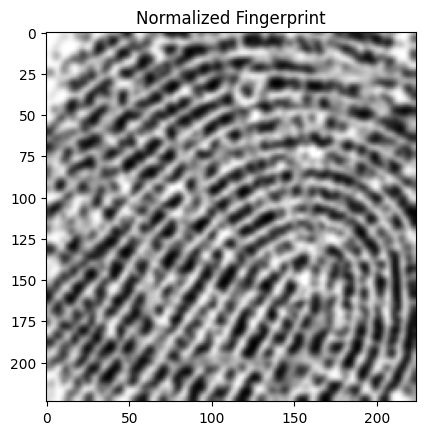

In [19]:
# Function to normalize the images to the range [0, 1]
def normalize_images(images):
    scaler = MinMaxScaler(feature_range=(0, 1))
    images_flat = [img.flatten() for img in images]
    images_scaled = scaler.fit_transform(images_flat)
    images_normalized = [img.reshape((224, 224)) for img in images_scaled]
    return images_normalized

# Normalize all preprocessed images
train_images_normalized = normalize_images(train_images_preprocessed)
real_images_normalized = normalize_images(real_images_preprocessed)

# Example: Display the first normalized image
plt.imshow(train_images_normalized[0], cmap='gray')
plt.title("Normalized Fingerprint")
plt.show()

In [20]:
# Edge Case Handling: Check for empty or corrupted images
def check_for_corrupted_images(images):
    valid_images = []
    for img in images:
        if img is None or img.size == 0:
            print("Corrupted image detected!")
        else:
            valid_images.append(img)
    return valid_images

# Filter out corrupted images from the dataset
train_images_valid = check_for_corrupted_images(train_images)
real_images_valid = check_for_corrupted_images(real_images)


In [21]:
# Function to skeletonize an image
def skeletonize_image(img):
    # Convert to binary using a threshold
    _, binary_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

    # Skeletonize the image using skimage
    skeleton = skeletonize(binary_img // 255)  # Convert binary to 0-1 range
    return skeleton.astype(np.uint8) * 255  # Convert back to 0-255 range


In [22]:
# Crossing Number Algorithm for Minutiae Detection
def calculate_crossing_number(img):
    """
    Detect minutiae points using the Crossing Number algorithm.
    :param img: Skeletonized binary image
    :return: List of minutiae points (type, location, orientation)
    """
    minutiae = []
    rows, cols = img.shape

    # Define the 3x3 neighborhood for calculating the crossing number
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            if img[i, j] == 255:  # Check if the pixel is a ridge
                # Extract 3x3 neighborhood
                neighborhood = [
                    img[i-1, j-1], img[i-1, j], img[i-1, j+1],
                    img[i, j+1], img[i+1, j+1], img[i+1, j],
                    img[i+1, j-1], img[i, j-1], img[i-1, j-1]
                ]

                # Count transitions from 0 to 1 in the neighborhood
                crossing_number = sum((neighborhood[k] == 0 and neighborhood[k+1] == 255) for k in range(8))

                # Identify ridge endings (CN=1) and bifurcations (CN=3)
                if crossing_number == 1:
                    minutiae.append(('ending', (j, i)))
                elif crossing_number == 3:
                    minutiae.append(('bifurcation', (j, i)))

    return minutiae


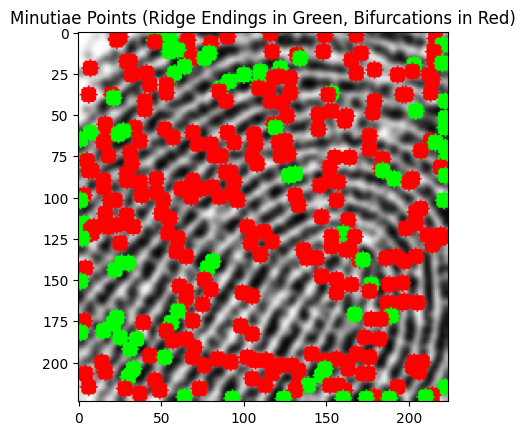

In [23]:
# Minutiae Visualization Function
def plot_minutiae(img, minutiae_points):
    """
    Visualize minutiae points on the fingerprint image.
    :param img: Original fingerprint image
    :param minutiae_points: List of minutiae points (type, location)
    """
    img_with_minutiae = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # Convert to BGR for color visualization
    for minutiae_type, (x, y) in minutiae_points:
        if minutiae_type == 'ending':
            cv2.circle(img_with_minutiae, (x, y), 5, (0, 255, 0), -1)  # Green for ridge endings
        elif minutiae_type == 'bifurcation':
            cv2.circle(img_with_minutiae, (x, y), 5, (0, 0, 255), -1)  # Red for bifurcations
    return img_with_minutiae

# Processed train and real images from Section 1
skeletonized_train_images = [skeletonize_image(img) for img in train_images_preprocessed]
skeletonized_real_images = [skeletonize_image(img) for img in real_images_preprocessed]

# Detect minutiae points in a sample skeletonized image
sample_skeleton = skeletonized_train_images[0]
minutiae_points = calculate_crossing_number(sample_skeleton)

# Visualize minutiae points on the original image
visualized_minutiae = plot_minutiae(train_images_preprocessed[0], minutiae_points)

# Display the image with minutiae points
plt.imshow(cv2.cvtColor(visualized_minutiae, cv2.COLOR_BGR2RGB))
plt.title("Minutiae Points (Ridge Endings in Green, Bifurcations in Red)")
plt.show()

In [126]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

In [127]:
# Step 1: Preprocess the image (no need to call imread again)
def preprocess_image(image, target_size=(224, 224)):
    image = cv2.resize(image, target_size)  # Resize to target size
    image = image.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]
    return image


# Step 2: Load images with labels
def load_images_with_labels(folder_path):
    images = []
    labels = []

    # Ensure the folder exists
    if not os.path.exists(folder_path):
        print(f"Error: The folder {folder_path} does not exist.")
        return images, labels

    # Loop over all images in the folder
    for img_id, img_name in enumerate(sorted(os.listdir(folder_path))):
        img_path = os.path.join(folder_path, img_name)
        
        # Only process .bmp files
        if img_name.lower().endswith(".bmp"):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
            if img is not None:
                img = preprocess_image(img)  # Preprocess image (no need to call imread here)
                images.append(img)
                labels.append(img_id)  # Assign an arbitrary label (or modify as needed)

    images = np.array(images)
    labels = np.array(labels)
    
    print(f"Loaded {len(images)} images with {len(np.unique(labels))} unique labels.")
    
    return images, labels

In [128]:

# Step 3: Generate pairs for the Siamese network
def create_pairs(images, labels):
    pairs = []
    pair_labels = []
    
    unique_labels = np.unique(labels)
    label_to_images = {label: np.where(labels == label)[0] for label in unique_labels}
    
    for label in unique_labels:
        same_label_images = label_to_images[label]
        
        # Create positive pairs (same label)
        for i in range(len(same_label_images)):
            for j in range(i + 1, len(same_label_images)):
                pairs.append([images[same_label_images[i]], images[same_label_images[j]]])
                pair_labels.append(1)  # Same label -> 1 (match)

        # Create negative pairs (different labels)
        for other_label in unique_labels:
            if other_label != label:
                diff_label_images = label_to_images[other_label]
                for i in range(len(same_label_images)):
                    for j in range(len(diff_label_images)):
                        pairs.append([images[same_label_images[i]], images[diff_label_images[j]]])
                        pair_labels.append(0)  # Different labels -> 0 (non-match)

    pairs = np.array(pairs)
    pair_labels = np.array(pair_labels)
    
    return pairs, pair_labels


In [129]:
def build_siamese_network(input_shape):
    # Define two input layers for the two images
    input1 = Input(shape=input_shape)
    input2 = Input(shape=input_shape)

    # Build the base network for both inputs
    base_network = tf.keras.Sequential([
        Conv2D(64, (10, 10), activation='relu', input_shape=input_shape),
        Flatten(),
        Dense(128, activation='relu'),
    ])

    # Process both inputs through the base network
    processed_input1 = base_network(input1)
    processed_input2 = base_network(input2)

    # Compute the absolute difference between the two processed inputs
    distance = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))([processed_input1, processed_input2])

    # Add a fully connected layer to output the similarity score
    output = Dense(1, activation='sigmoid')(distance)

    # Create and return the Siamese network model
    model = Model(inputs=[input1, input2], outputs=output)

    return model

# Example input shape for 224x224 RGB images
input_shape = (224, 224, 3)
siamese_network = build_siamese_network(input_shape)
siamese_network.summary()


D:\Softwares\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_44 (InputLayer)   │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_45 (InputLayer)   │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_14 (Sequential)    │ (None, 128)               │     378,694,592 │ input_layer_44[0][0],      │
│                               │                           │                 │ input_layer_45[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda_16 (Lambda)            │ (None, 128)               │               0 │ sequential_14[0][0],       │
│                               │                           │                 │ sequential_14[1][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_33 (Dense)              │ (None, 1)                 │             129 │ lambda_16[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 378,694,721 (1.41 GB)

 Trainable params: 378,694,721 (1.41 GB)

 Non-trainable params: 0 (0.00 B)

In [130]:
# Step 5: Data Generator for Siamese Network
class SiameseDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size=32, target_size=(224, 224)):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.indexes = np.arange(len(self.images))
    
    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        pairs, pair_labels = self.__data_generation(batch_indexes)
        return [pairs[:, 0], pairs[:, 1]], pair_labels
    
    def on_epoch_end(self):
        # Shuffle data after each epoch
        np.random.shuffle(self.indexes)
    
    def __data_generation(self, batch_indexes):
        # Generate pairs and labels for the given batch
        batch_images = self.images[batch_indexes]
        batch_labels = self.labels[batch_indexes]
        
        pairs = []
        pair_labels = []
        
        unique_labels = np.unique(batch_labels)
        label_to_images = {label: np.where(batch_labels == label)[0] for label in unique_labels}
        
        for label in unique_labels:
            same_label_images = label_to_images[label]
            
            # Create positive pairs (same label)
            for i in range(len(same_label_images)):
                for j in range(i + 1, len(same_label_images)):
                    pairs.append([batch_images[same_label_images[i]], batch_images[same_label_images[j]]])
                    pair_labels.append(1)  # Same label -> 1 (match)

            # Create negative pairs (different labels)
            for other_label in unique_labels:
                if other_label != label:
                    diff_label_images = label_to_images[other_label]
                    for i in range(len(same_label_images)):
                        for j in range(len(diff_label_images)):
                            pairs.append([batch_images[same_label_images[i]], batch_images[diff_label_images[j]]])
                            pair_labels.append(0)  # Different labels -> 0 (non-match)

        pairs = np.array(pairs)
        pair_labels = np.array(pair_labels)
        
        return pairs, pair_labels



In [136]:
class SiameseDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size=32, target_size=(224, 224)):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.indexes = np.arange(len(self.images))
    
    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        # Generate one batch of data
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [self.images[i] for i in batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes]

        # Resize images
        batch_images = np.array([cv2.resize(img, self.target_size) for img in batch_images])
        batch_labels = np.array(batch_labels)

        # Create image pairs
        pairs, pair_labels = self.create_pairs(batch_images, batch_labels)
        
        return [pairs[:, 0], pairs[:, 1]], pair_labels

    def create_pairs(self, images, labels):
        # Assuming you have a function that creates pairs of images
        pairs = []
        pair_labels = []
        for i in range(len(images)):
            # Create positive pairs (same class)
            for j in range(i + 1, len(images)):
                if labels[i] == labels[j]:
                    pairs.append([images[i], images[j]])
                    pair_labels.append(1)  # Same label -> 1 (match)
                else:
                    pairs.append([images[i], images[j]])
                    pair_labels.append(0)  # Different labels -> 0 (non-match)

        return np.array(pairs), np.array(pair_labels)


In [ ]:
# Step 6: Train the Siamese network
train_folder_path = './dataset/train_data'  # Update with the correct path
train_images_preprocessed, train_labels = load_images_with_labels(train_folder_path)

# Ensure images are resized to the correct input shape (e.g., 224x224)
input_shape = (224, 224, 3)  # Adjust based on your preprocessing
train_images_resized = np.array([cv2.resize(img, (224, 224)) for img in train_images_preprocessed])

# Split data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images_resized, train_labels, test_size=0.2)

# Create the Siamese network
siamese_network = build_siamese_network(input_shape)

# Set up the ModelCheckpoint callback
checkpoint = ModelCheckpoint("siamese_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1)

# Create the data generators
train_generator = SiameseDataGenerator(train_images, train_labels, batch_size=32)
val_generator = SiameseDataGenerator(val_images, val_labels, batch_size=32)

# Compile the model first
siamese_network.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = siamese_network.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[checkpoint]
)


# Save the trained model
siamese_network.save("siamese_network.keras")

# Optionally, plot training history
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Siamese Network Training History')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()